# Feature Engineering

---

1. Import packages
2. Load data
3. Feature engineering

---

## 1. Import packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os 
import pandas as pd
import seaborn as sns
import datetime
import pickle
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


---
## 2. Load data

In [2]:
df = pd.read_csv('./clean_data_after_eda.csv')
df["date_activ"] = pd.to_datetime(df["date_activ"], format='%Y-%m-%d')
df["date_end"] = pd.to_datetime(df["date_end"], format='%Y-%m-%d')
df["date_modif_prod"] = pd.to_datetime(df["date_modif_prod"], format='%Y-%m-%d')
df["date_renewal"] = pd.to_datetime(df["date_renewal"], format='%Y-%m-%d')

In [3]:
df.head(3)

,Unnamed: 0,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,...,mean_3m_price_off_peak_var,mean_3m_price_peak_var,mean_3m_price_mid_peak_var,mean_3m_price_off_peak_fix,mean_3m_price_peak_fix,mean_3m_price_mid_peak_fix,mean_3m_price_p1,mean_3m_price_p2,mean_3m_price_p3,churn
0,0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,...,0.131756,0.092638,0.036909,42.497907,12.218665,8.145777,42.629663,12.311304,8.182687,1
1,1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,...,0.147600,0.000000,0.000000,44.444710,0.000000,0.000000,44.592310,0.000000,0.000000,0
2,2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,...,0.167798,0.088409,0.000000,44.444710,0.000000,0.000000,44.612508,0.088409,0.000000,0


In [4]:
df.columns

Index(['Unnamed: 0', 'id', 'channel_sales', 'cons_12m', 'cons_gas_12m',
       'cons_last_month', 'date_activ', 'date_end', 'date_modif_prod',
       'date_renewal', 'forecast_cons_12m', 'forecast_cons_year',
       'forecast_discount_energy', 'forecast_meter_rent_12m',
       'forecast_price_energy_off_peak', 'forecast_price_energy_peak',
       'forecast_price_pow_off_peak', 'has_gas', 'imp_cons',
       'margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act',
       'net_margin', 'num_years_antig', 'origin_up', 'pow_max',
       'mean_year_price_off_peak_var', 'mean_year_price_peak_var',
       'mean_year_price_mid_peak_var', 'mean_year_price_off_peak_fix',
       'mean_year_price_peak_fix', 'mean_year_price_mid_peak_fix',
       'mean_year_price_p1', 'mean_year_price_p2', 'mean_year_price_p3',
       'mean_6m_price_off_peak_var', 'mean_6m_price_peak_var',
       'mean_6m_price_mid_peak_var', 'mean_6m_price_off_peak_fix',
       'mean_6m_price_peak_fix', 'mean_6m_price_mid_peak_

In [5]:
df.shape

(14605, 54)

---

## 3. Feature engineering

### Difference between off-peak prices in December and preceding January

Below is the code created by your colleague to calculate the feature described above. Use this code to re-create this feature and then think about ways to build on this feature to create features with a higher predictive power.

In [6]:
price_df = pd.read_csv('price_data.csv')
price_df["price_date"] = pd.to_datetime(price_df["price_date"], format='%Y-%m-%d')
price_df.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


In [7]:
# Group off-peak prices by companies and month
monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean'}).reset_index()

# Get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference
diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}), jan_prices.drop(columns='price_date'), on='id')
diff['offpeak_diff_dec_january_energy'] = diff['dec_1'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['dec_2'] - diff['price_off_peak_fix']
diff = diff[['id', 'offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power']]
diff.head()

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779
2,0010bcc39e42b3c2131ed2ce55246e3c,0.050443,1.500000
3,0010ee3855fdea87602a5b7aba8e42de,-0.010018,0.162916
4,00114d74e963e47177db89bc70108537,-0.003994,-0.000001


Sub Task 1

In [8]:
df_new = pd.merge(df, price_df, on='id', how ='inner')


In [9]:
df_new.head()

,Unnamed: 0,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,...,mean_3m_price_p2,mean_3m_price_p3,churn,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,...,12.311304,8.182687,1,2015-01-01,0.125976,0.103395,0.071536,40.565969,24.339581,16.226389
1,0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,...,12.311304,8.182687,1,2015-02-01,0.125976,0.103395,0.071536,40.565969,24.339581,16.226389
2,0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,...,12.311304,8.182687,1,2015-03-01,0.125976,0.103395,0.071536,40.565973,24.339578,16.226383
3,0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,...,12.311304,8.182687,1,2015-04-01,0.125976,0.103395,0.071536,40.565973,24.339578,16.226383
4,0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,...,12.311304,8.182687,1,2015-05-01,0.125976,0.103395,0.071536,40.565973,24.339578,16.226383


## Categorical 

remove column `id` because this column not need into model

In [11]:
df_new.drop(['id'], axis=1, inplace=True)

remove the date column

In [12]:
#Remove the date columns 
df_new.drop(columns=['date_activ','date_end','date_modif_prod','date_renewal', 'price_date'],axis=1,inplace=True)

Replace unique value at column `has_gas`, replace t for 1 and f for 0 

In [13]:
df_new['has_gas']=df_new['has_gas'].replace(['t','f'],[1,0])

One-Hot

In [14]:
df_new['channel_sales']=df_new['channel_sales'].fillna('null_values_channel')
df_new['channel_sales']=df_new['channel_sales'].apply(lambda x:x[:4])
categories_channel=pd.get_dummies(df_new[['channel_sales']])
categories_channel.head()

,channel_sales_MISS,channel_sales_epum,channel_sales_ewpa,channel_sales_fixd,channel_sales_foos,channel_sales_lmke,channel_sales_sddi,channel_sales_usil
0,0,0,0,0,1,0,0,0
1,0,0,0,0,1,0,0,0
2,0,0,0,0,1,0,0,0
3,0,0,0,0,1,0,0,0
4,0,0,0,0,1,0,0,0


In [15]:
#for the column origin_up, first fill the null value 
df_new['origin_up']=df_new['origin_up'].fillna('null_values_origin')

In [16]:
df_new['origin_up']=df_new['origin_up'].apply(lambda x:x[:4])
categories_origin= pd.get_dummies(df_new[['origin_up']])
categories_origin.head()

,origin_up_MISS,origin_up_ewxe,origin_up_kamk,origin_up_ldks,origin_up_lxid,origin_up_usap
0,0,0,0,0,1,0
1,0,0,0,0,1,0
2,0,0,0,0,1,0
3,0,0,0,0,1,0
4,0,0,0,0,1,0


In [17]:
#Use the common index to merge 
df_new=pd.merge(df_new,categories_channel,left_index=True,right_index=True)
df_new=pd.merge(df_new,categories_origin,left_index=True,right_index=True)

In [18]:
train=df_new.drop(['channel_sales','origin_up'],axis=1)
train.head()

,Unnamed: 0,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,...,channel_sales_foos,channel_sales_lmke,channel_sales_sddi,channel_sales_usil,origin_up_MISS,origin_up_ewxe,origin_up_kamk,origin_up_ldks,origin_up_lxid,origin_up_usap
0,0,0,54946,0,0.0,0,0.0,1.78,0.114481,0.098142,...,1,0,0,0,0,0,0,0,1,0
1,0,0,54946,0,0.0,0,0.0,1.78,0.114481,0.098142,...,1,0,0,0,0,0,0,0,1,0
2,0,0,54946,0,0.0,0,0.0,1.78,0.114481,0.098142,...,1,0,0,0,0,0,0,0,1,0
3,0,0,54946,0,0.0,0,0.0,1.78,0.114481,0.098142,...,1,0,0,0,0,0,0,0,1,0
4,0,0,54946,0,0.0,0,0.0,1.78,0.114481,0.098142,...,1,0,0,0,0,0,0,0,1,0


In [20]:
train=train.drop(['Unnamed: 0'], axis=1)

Numerical

Meassure Distribution

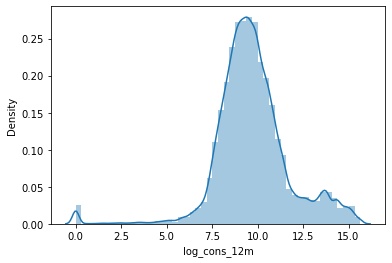

In [21]:
#First for the cons_12, remove the negative values and apply a log tranformation
train.loc[train.cons_12m<0,'cons_12m']=np.nan
train['cons_12m']=train['cons_12m'].dropna()
train['log_cons_12m']=train['cons_12m'].apply(lambda x:np.log(1+x))
sns.distplot(train['log_cons_12m']);

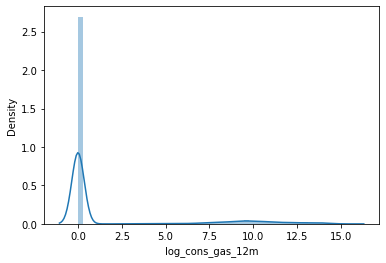

In [22]:
train.loc[train.cons_gas_12m<0,'cons_gas_12m']=np.nan
train['cons_gas_12m']=train['cons_gas_12m'].dropna()
train['log_cons_gas_12m']=train['cons_gas_12m'].apply(lambda x:np.log(1+x))
sns.distplot(train['log_cons_gas_12m']);

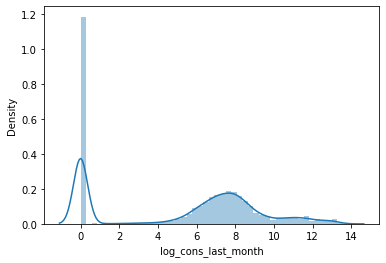

In [23]:
train.loc[train.cons_last_month<0,'cons_last_month']=np.nan
train['cons_last_month']=train['cons_last_month'].dropna()
train['log_cons_last_month']=train['cons_last_month'].apply(lambda x:np.log(1+x))
sns.distplot(train['log_cons_last_month']);

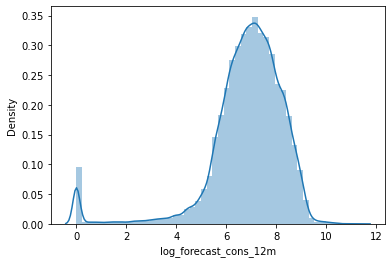

In [24]:
train.loc[train.forecast_cons_12m<0,'forecast_cons_12m']=np.nan
train['forecast_cons_12m']=train['forecast_cons_12m'].dropna()
train['log_forecast_cons_12m']=train['forecast_cons_12m'].apply(lambda x:np.log(1+x))
sns.distplot(train['log_forecast_cons_12m']);

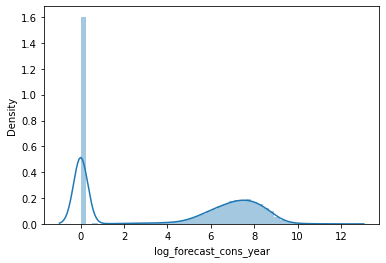

In [25]:
train.loc[train.forecast_cons_year<0,'forecast_cons_year']=np.nan
train['forecast_cons_year']=train['forecast_cons_year'].dropna()
train['log_forecast_cons_year']=train['forecast_cons_year'].apply(lambda x:np.log(1+x))
sns.distplot(train['log_forecast_cons_year']);

<AxesSubplot:xlabel='log_forecast_meter_rent_12m', ylabel='Density'>

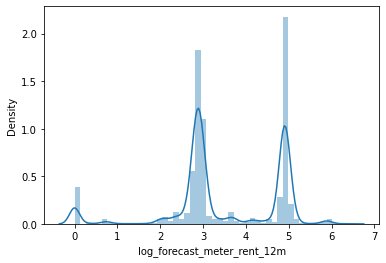

In [26]:
train.loc[train.forecast_meter_rent_12m<0,'forecast_meter_rent_12m']=np.nan
train['forecast_meter_rent_12m']=train['forecast_meter_rent_12m'].dropna()
train['log_forecast_meter_rent_12m']=train['forecast_meter_rent_12m'].apply(lambda x:np.log(1+x))
sns.distplot(train['log_forecast_meter_rent_12m'])

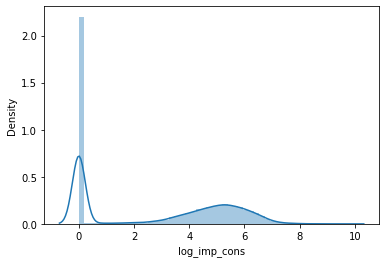

In [27]:
train.loc[train.imp_cons<0,'imp_cons']=np.nan
train['imp_cons']=train['imp_cons'].dropna()
train['log_imp_cons']=train['imp_cons'].apply(lambda x:np.log(1+x))
sns.distplot(train['log_imp_cons']);

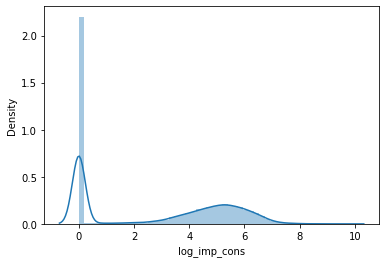

In [28]:
train.loc[train.imp_cons<0,'imp_cons']=np.nan
train['imp_cons']=train['imp_cons'].dropna()
train['log_imp_cons']=train['imp_cons'].apply(lambda x:np.log(1+x))
sns.distplot(train['log_imp_cons']);

In [29]:
train=train.drop(['cons_12m','cons_gas_12m','cons_last_month','forecast_cons_12m','forecast_cons_year','forecast_meter_rent_12m','imp_cons'],axis=1)
train.head()

,forecast_discount_energy,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,...,origin_up_ldks,origin_up_lxid,origin_up_usap,log_cons_12m,log_cons_gas_12m,log_cons_last_month,log_forecast_cons_12m,log_forecast_cons_year,log_forecast_meter_rent_12m,log_imp_cons
0,0.0,0.114481,0.098142,40.606701,1,25.44,25.44,2,678.99,3,...,0,1,0,0.0,10.914124,0.0,0.0,0.0,1.022451,0.0
1,0.0,0.114481,0.098142,40.606701,1,25.44,25.44,2,678.99,3,...,0,1,0,0.0,10.914124,0.0,0.0,0.0,1.022451,0.0
2,0.0,0.114481,0.098142,40.606701,1,25.44,25.44,2,678.99,3,...,0,1,0,0.0,10.914124,0.0,0.0,0.0,1.022451,0.0
3,0.0,0.114481,0.098142,40.606701,1,25.44,25.44,2,678.99,3,...,0,1,0,0.0,10.914124,0.0,0.0,0.0,1.022451,0.0
4,0.0,0.114481,0.098142,40.606701,1,25.44,25.44,2,678.99,3,...,0,1,0,0.0,10.914124,0.0,0.0,0.0,1.022451,0.0


Meassure Calue Correlation with use Hitmap

In [30]:
#Calculate correlation of variables
corr_hist=df_new.corr()

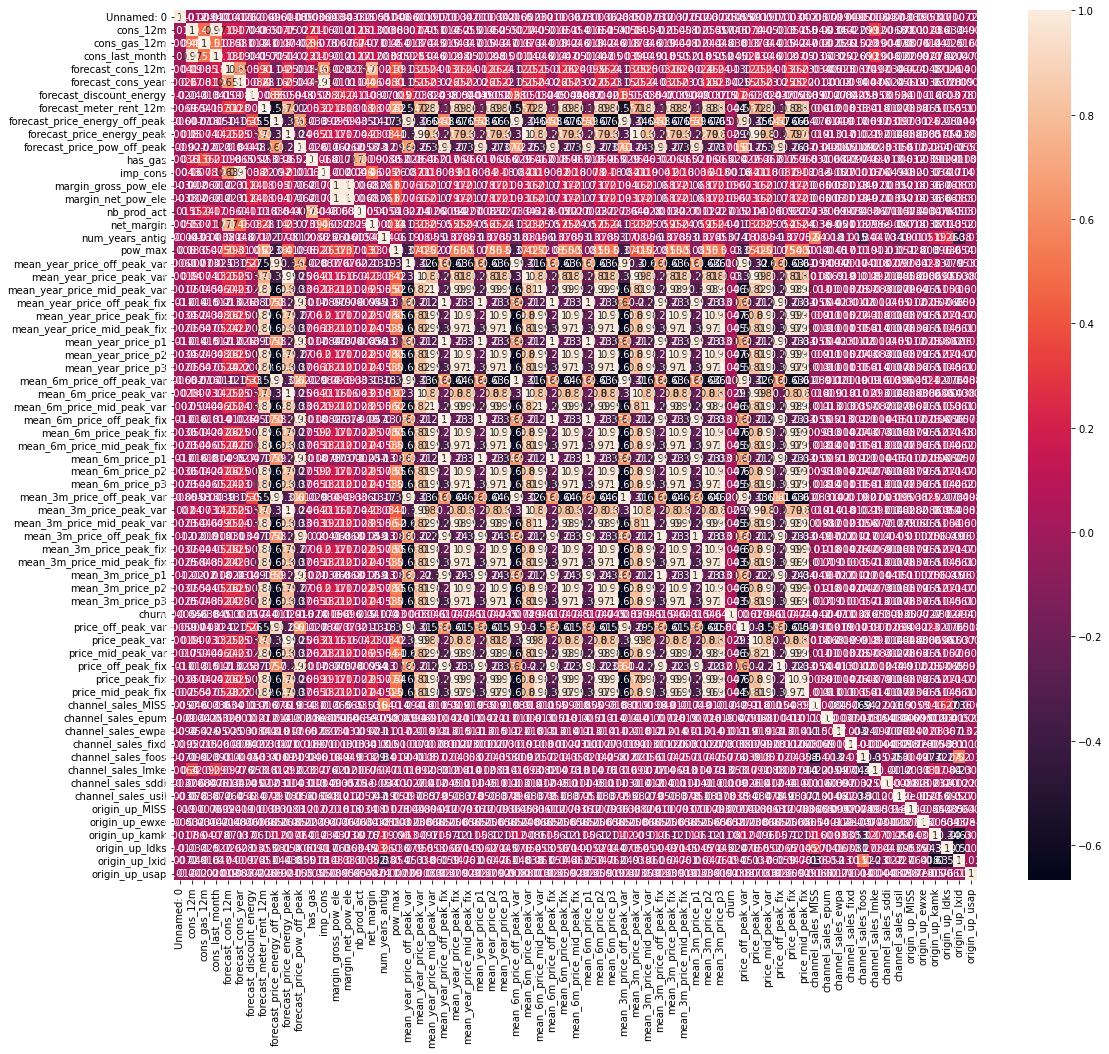

In [31]:
plt.figure(figsize=(18,16))
sns.heatmap(corr_hist,xticklabels=corr_hist.columns.values,
           yticklabels=corr_hist.columns.values,annot=True,annot_kws={'size':10})
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [32]:
#Calculate correlation of variables
corr_train=train.corr()

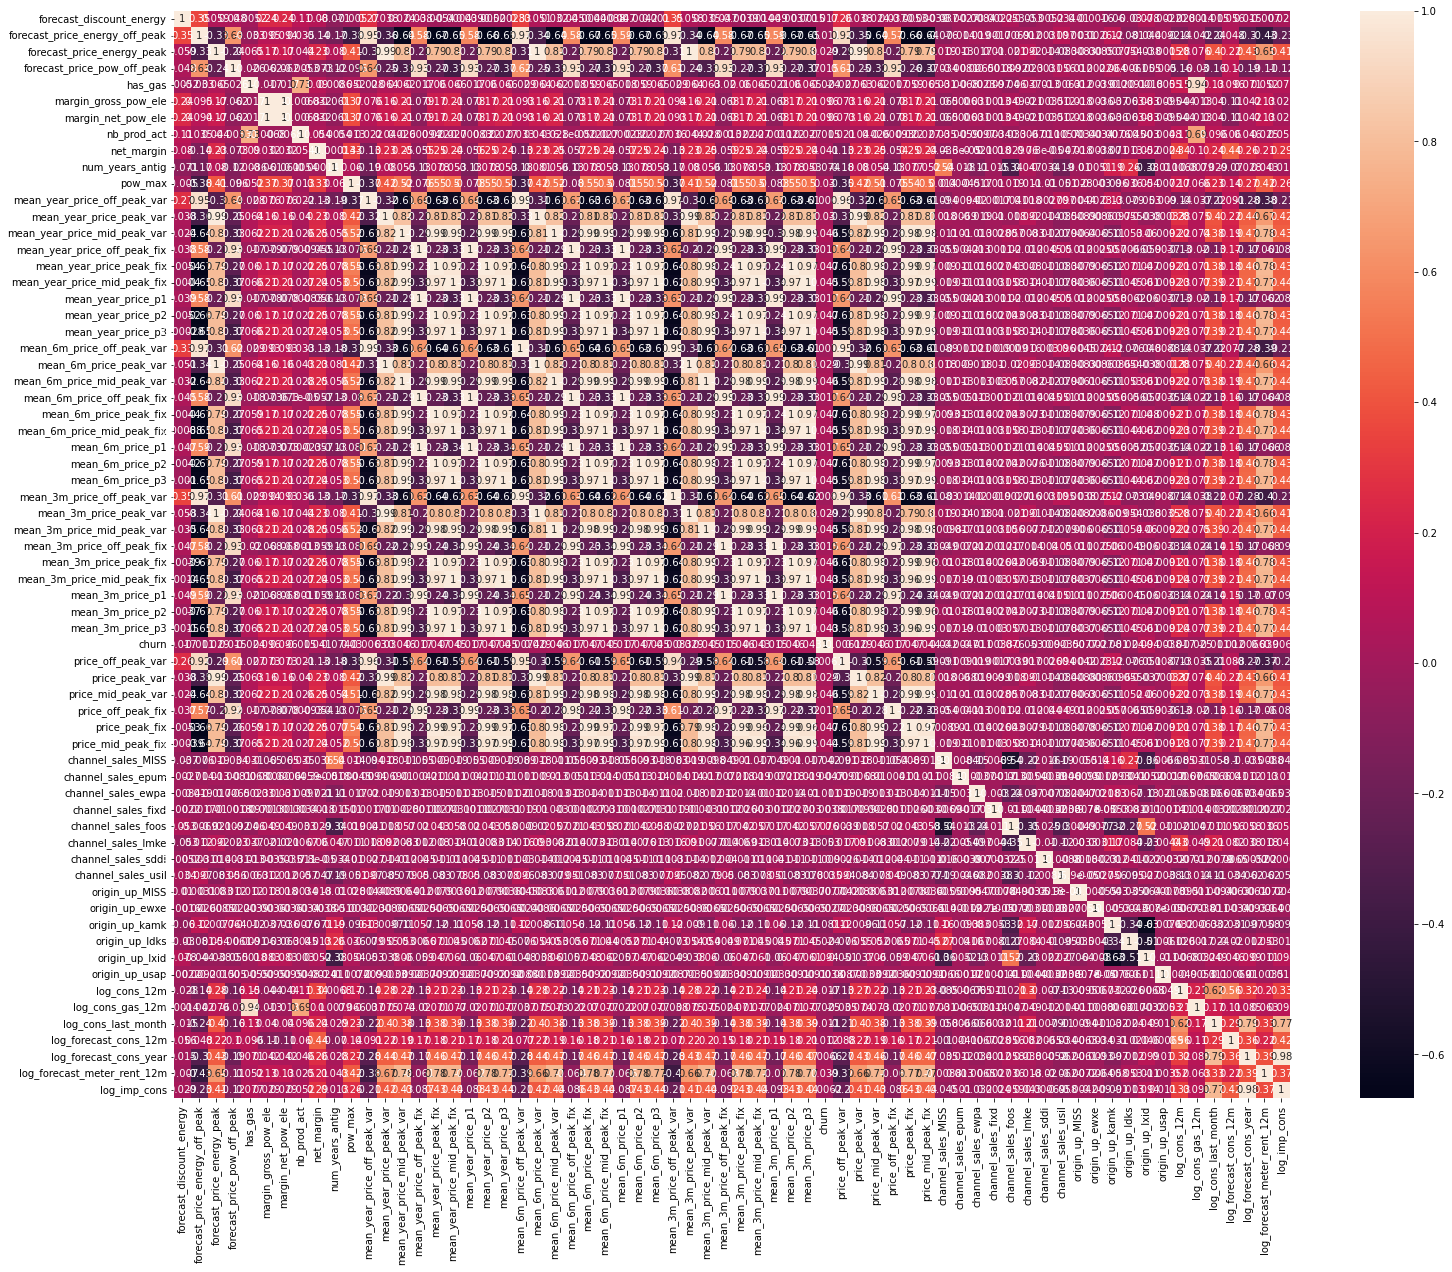

In [33]:
plt.figure(figsize=(25,20))
sns.heatmap(corr_train,xticklabels=corr_train.columns.values,
           yticklabels=corr_train.columns.values,annot=True,annot_kws={'size':10})
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

Removing the num_years_antig since they are provides the same information.

In [34]:
train.drop(columns=['num_years_antig'],inplace=True)

Outliers

In [35]:
#I will use IQR method to detect outliers
def remove_outliers(df,col):
    df.loc[df[col]<0,col]=df[col].mean()
    q1=df[col].quantile(.25)
    q3=df[col].quantile(.75)
    iqr=q3-q1
    upper_bound=q3+(iqr*1.5)
    lower_bound=q1-(iqr*1.5)
    df=df[(lower_bound<df[col])|(df[col]<upper_bound)]

In [40]:
remove_outliers(train,'mean_year_price_off_peak_var')
remove_outliers(train,'mean_year_price_peak_var')
remove_outliers(train,'mean_year_price_mid_peak_var')
remove_outliers(train,'mean_year_price_off_peak_fix')
remove_outliers(train,'mean_year_price_peak_fix')
remove_outliers(train,'mean_year_price_mid_peak_fix')
remove_outliers(train,'log_cons_12m')
remove_outliers(train,'log_cons_gas_12m')
remove_outliers(train,'log_cons_last_month')
remove_outliers(train,'log_forecast_cons_12m')
remove_outliers(train,'log_forecast_meter_rent_12m')
remove_outliers(train,'log_forecast_cons_year')
remove_outliers(train,'log_imp_cons')
remove_outliers(train,'forecast_discount_energy')
remove_outliers(train,'forecast_price_energy_off_peak')
remove_outliers(train,'forecast_price_energy_peak')
remove_outliers(train,'forecast_price_pow_off_peak')
remove_outliers(train,'margin_gross_pow_ele')
remove_outliers(train,'margin_net_pow_ele')
remove_outliers(train,'net_margin')
remove_outliers(train,'pow_max')
remove_outliers(train,'forecast_price_energy_off_peak')

In [41]:
df=train.dropna()

In [42]:
df.isnull().sum().sort_values(ascending = False).to_frame

<bound method Series.to_frame of forecast_discount_energy      0
mean_3m_price_mid_peak_fix    0
mean_3m_price_p2              0
mean_3m_price_p3              0
churn                         0
                             ..
mean_6m_price_p3              0
mean_3m_price_off_peak_var    0
mean_3m_price_peak_var        0
mean_3m_price_mid_peak_var    0
log_imp_cons                  0
Length: 65, dtype: int64>

In [43]:
df.to_csv('feature_engineering.csv', index = False)

Sub-Task 2

In [44]:
# Bagi df menjadi fitur (X) dan variabel target (y)
X = df.drop(columns=['churn'])
y = df['churn']

# Bagi data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inisialisasi model Random Forest
model = RandomForestClassifier()

# Latih model
model.fit(X_train, y_train)

# Lakukan prediksi
y_pred = model.predict(X_test)

# Evaluasi kinerja model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Tampilkan hasil evaluasi
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0


Pros of Random Forests:
1. Able to deal with irrelevant features: Random Forest can automatically select the most informative features and ignore those that are irrelevant, thereby addressing the problem of multicollinearity.
2. Generate stable predictions: By building many decision trees randomly, Random Forest can generate stable predictions and have low bias
3. Able to overcome overfitting: Through techniques such as aggregation and the use of random subsets in tree construction, Random Forest can reduce the risk of overfitting and increase the generalizability of the model.
4. Can be used for both classification and regression: Random Forest is not only effective in classification problems, but also in regression problems, so it can be applied in various types of prediction tasks.

Disadvantages of Random Forests:

1. Long training time: Random Forest involves training many decision trees, which takes longer time than some other algorithms.
2. Difficult to interpret: Because the Random Forest consists of many decision trees, interpretation of the overall model can be difficult. Moreover, if there are many features, it is important to understand the importance of each feature in decision making.
3. Susceptible to overfitting of unbalanced data: If your dataset is class-imbalanced, the Random Forest is likely to give more weight to the majority class, which can result in overfitting to the minority class.

To explain the performance of the model based on what I have done so far, I can use the evaluation results that I have done. In this case, the evaluation results show accuracy, precision, recall, and an F1-score of 1.0. Here are some points that I can explain based on these results:

Fit to data: The Random Forest model that I've trained fits perfectly with the data used. This is demonstrated by perfect accuracy, which means the model is able to correctly predict churn for all samples in the test data.

Predictive reliability: The Random Forest model has provided very good prediction results with a precision, recall, and an F1-score of 1.0. This shows that the model has a very good ability to identify customers who are most likely to churn.

Generalizability: Although I have not provided information on how the model is separated between training data and test data, optimal evaluation results indicate a model's ability to generalize well. This means the model may be able to predict churn with high accuracy on data it has never seen before.

Evaluation limitations: It is important to note that the results of this excellent evaluation only reflect the model's performance on the data used for the evaluation. Models that closely fit certain training and test data can lead to overfitting and unrealistic performance on unfamiliar data.

Wider assessment: It is important to carry out broader evaluations and consider other factors such as model interpretability, computational complexity, and the ability of the model to handle situations of imbalance in the dataset. This will provide a more complete picture of the performance and usefulness of the Random Forest model in this case.

To relate model performance to client financial performance with discount proposition introduction, here are the steps I can follow:

Calculating the number of customers predicted to churn: Use a Random Forest model that has been trained to predict churn on customer data. Count the number of customers predicted to churn.

Calculating the proportion of customers predicted to churn: Divide the number of customers predicted to churn by the total number of customers to get the proportion of customers predicted to churn.

Calculating potential savings with a discount: Use the proportion of customers predicted to churn to estimate the number of customers who could get the discount. Assume that the customer predicted to churn will get a 20% discount.

Calculating total savings: Multiply the number of customers who can get a discount by the discount rate (20%) and the average cost per customer to get an estimate of the total savings a client can achieve using the model.

The assumptions I need to make to reach this conclusion include:

Assume that a 20% discount proposition will be effective in preventing churn and encouraging customers to subscribe.
Assume that the client's average cost per customer can be obtained from the client's financial data or other relevant information.
Assume that all the customers predicted to churn will actually take the discount and stay subscribed.
After calculating the total savings, I can explain to clients how much money they can save using my model. Be sure to include the assumptions I made in my explanation.